In [1]:
!pip install dagster dagster-webserver yfinance scikit-learn pandas matplotlib seaborn

In [2]:
# Data handling
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data source
import yfinance as yf

# ML
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Dagster
from dagster import asset, Definitions

In [3]:
@asset
def stock_data():
    """
    Downloads Apple (AAPL) stock price data from Yahoo Finance.
    This is the root data asset for the pipeline.
    """
    df = yf.download("AAPL", start="2018-01-01", end="2024-01-01")
    return df
df = stock_data()
df.head()

/tmp/ipython-input-3739246681.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AAPL", start="2018-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2018-01-02,40.341881,40.351250,39.639305,39.850080,102223600
2018-01-03,40.334854,40.878181,40.271625,40.405112,118071600
2018-01-04,40.522221,40.625266,40.299739,40.407465,89738400
2018-01-05,40.983578,41.070228,40.526904,40.618239,94640000
2018-01-08,40.831356,41.126437,40.732992,40.831356,82271200


/tmp/ipython-input-3739246681.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AAPL", start="2018-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed


<Figure size 1000x400 with 0 Axes>

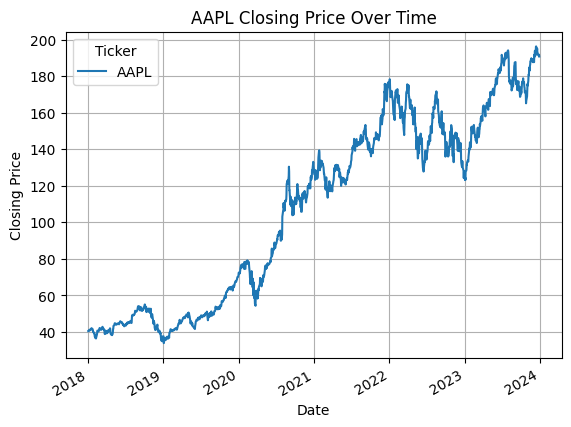

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
count,1509.000000,1509.000000,1509.000000,1509.000000,1.509000e+03
mean,107.824407,108.952048,106.584251,107.724452,1.073284e+08
std,50.934094,51.407897,50.406557,50.893121,5.513287e+07
min,33.799679,34.638787,33.754514,34.225174,2.404830e+07
25%,51.237431,52.040457,50.858421,51.374825,7.078370e+07
50%,120.464729,121.718799,118.965616,120.605510,9.296430e+07
75%,150.220795,151.972484,148.223238,150.046333,1.280440e+08
max,196.256577,197.752444,195.156944,196.167422,4.265100e+08


In [4]:
@asset
def eda(stock_data: pd.DataFrame):
    """
    Performs exploratory data analysis on stock price data.
    Generates a closing price trend and returns summary statistics.
    """
    plt.figure(figsize=(10, 4))
    stock_data['Close'].plot(title="AAPL Closing Price Over Time")
    plt.xlabel("Date")
    plt.ylabel("Closing Price")
    plt.grid(True)
    plt.show()

    return stock_data.describe()
eda_summary = eda(stock_data())
eda_summary

In [5]:
@asset
def features(stock_data: pd.DataFrame):
    """
    Feature engineering for ML models.
    Creates returns and moving averages.
    """
    df = stock_data.copy()

    df['Return'] = df['Close'].pct_change()
    df['MA_10'] = df['Close'].rolling(window=10).mean()
    df['MA_50'] = df['Close'].rolling(window=50).mean()

    df = df.dropna()
    return df
features_df = features(stock_data())
features_df.head()

/tmp/ipython-input-3739246681.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AAPL", start="2018-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,Return,MA_10,MA_50
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,
Date,,,,,,,,
2018-03-14,41.959576,42.448681,41.811432,42.401653,117473600,-0.008502,41.780395,40.432457
2018-03-15,42.008957,42.382843,41.872575,41.973686,90975200,0.001177,41.866224,40.465798
2018-03-16,41.860806,42.119465,41.766745,42.008945,157618800,-0.003527,41.908784,40.496317
2018-03-19,41.221214,41.731482,40.835574,41.696212,133787200,-0.015279,41.873040,40.510297
2018-03-20,41.207104,41.573932,41.136559,41.207104,78597600,-0.000342,41.839414,40.514768


In [6]:
@asset
def split_data(features: pd.DataFrame):
    """
    Splits features into train and test sets.
    Shared by all ML models.
    """
    X = features[['Return', 'MA_10', 'MA_50']]
    y = features['Close']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = split_data(features(stock_data()))
X_train.shape, X_test.shape

/tmp/ipython-input-3739246681.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AAPL", start="2018-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed


((1168, 3), (292, 3))

In [7]:
@asset
def decision_tree(split_data):
    """
    Decision Tree regression model.
    """
    X_train, X_test, y_train, y_test = split_data

    model = DecisionTreeRegressor(random_state=42)
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)

    return mse
dt_mse = decision_tree(split_data(features(stock_data())))
dt_mse

/tmp/ipython-input-3739246681.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AAPL", start="2018-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed


14.51845167549294

In [8]:
@asset
def random_forest(split_data):
    """
    Random Forest regression model.
    """
    X_train, X_test, y_train, y_test = split_data

    model = RandomForestRegressor(
        n_estimators=100,
        random_state=42
    )
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)

    return mse
rf_mse = random_forest(split_data(features(stock_data())))
rf_mse

/tmp/ipython-input-3739246681.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AAPL", start="2018-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


7.405871770026236

In [9]:
@asset
def gradient_boosting(split_data):
    """
    Gradient Boosting regression model.
    """
    X_train, X_test, y_train, y_test = split_data

    model = GradientBoostingRegressor(random_state=42)
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)

    return mse
gb_mse = gradient_boosting(split_data(features(stock_data())))
gb_mse

/tmp/ipython-input-3739246681.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AAPL", start="2018-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


7.49523819352618

In [10]:
@asset
def linear_regression(split_data):
    """
    Linear Regression baseline model.
    """
    X_train, X_test, y_train, y_test = split_data

    model = LinearRegression()
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)

    return mse
lr_mse = linear_regression(split_data(features(stock_data())))
lr_mse

/tmp/ipython-input-3739246681.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AAPL", start="2018-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed


9.75483431884175

In [11]:
defs = Definitions(
    assets=[
        stock_data,
        eda,
        features,
        split_data,
        decision_tree,
        random_forest,
        gradient_boosting,
        linear_regression
    ]
)

In [12]:
@asset
def stock_data():
    """
    UPDATED DATA RANGE to simulate new incoming data
    """
    df = yf.download("AAPL", start="2019-01-01", end="2024-01-01")
    return df

In [13]:
features_df = features(stock_data())
X_train, X_test, y_train, y_test = split_data(features_df)
decision_tree((X_train, X_test, y_train, y_test))
random_forest((X_train, X_test, y_train, y_test))
gradient_boosting((X_train, X_test, y_train, y_test))
linear_regression((X_train, X_test, y_train, y_test))

/tmp/ipython-input-3951613849.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AAPL", start="2019-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


10.52609336380599

In [14]:
%%writefile pipeline.py
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from dagster import asset, Definitions
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

@asset
def stock_data():
    return yf.download("AAPL", start="2019-01-01", end="2024-01-01")

@asset
def eda(stock_data: pd.DataFrame):
    plt.figure(figsize=(10,4))
    stock_data['Close'].plot(title="AAPL Closing Price Over Time")
    plt.show()
    return stock_data.describe()

@asset
def features(stock_data: pd.DataFrame):
    df = stock_data.copy()
    df['Return'] = df['Close'].pct_change()
    df['MA_10'] = df['Close'].rolling(10).mean()
    df['MA_50'] = df['Close'].rolling(50).mean()
    return df.dropna()

@asset
def split_data(features: pd.DataFrame):
    X = features[['Return', 'MA_10', 'MA_50']]
    y = features['Close']
    return train_test_split(X, y, test_size=0.2, random_state=42)

@asset
def decision_tree(split_data):
    X_train, X_test, y_train, y_test = split_data
    model = DecisionTreeRegressor(random_state=42)
    model.fit(X_train, y_train)
    return mean_squared_error(y_test, model.predict(X_test))

@asset
def random_forest(split_data):
    X_train, X_test, y_train, y_test = split_data
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)
    return mean_squared_error(y_test, model.predict(X_test))

@asset
def gradient_boosting(split_data):
    X_train, X_test, y_train, y_test = split_data
    model = GradientBoostingRegressor(random_state=42)
    model.fit(X_train, y_train)
    return mean_squared_error(y_test, model.predict(X_test))

@asset
def linear_regression(split_data):
    X_train, X_test, y_train, y_test = split_data
    model = LinearRegression()
    model.fit(X_train, y_train)
    return mean_squared_error(y_test, model.predict(X_test))

defs = Definitions(
    assets=[
        stock_data, eda, features, split_data,
        decision_tree, random_forest,
        gradient_boosting, linear_regression
    ]
)

Writing pipeline.py
